### Часть II: О линейной регрессии

In [2274]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import scipy as sp
from sklearn import linear_model
from scipy.stats import multivariate_normal
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('figure', **{'dpi': 300})
import warnings
warnings.filterwarnings('ignore')

1. Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания). Иначе говоря, мы будем “играть” за российские власти, которые пытаются понять, что делать, глядя на данные об эпидемии в мае 2020 года.

In [2225]:
data = pd.read_csv('owid-covid-data.csv')

In [2226]:
#фильтруем данные: Россия, начиная с 3 марта, заменяем 0.0 в столбце 'new_cases' на 1.
data_ru = data[data['location'] == 'Russia'][data['date'] >= '2020-03-03']
data_ru['new_cases'].replace(0, 1., inplace=True)
train = data_ru[:50]
# 1 сентября 2020 года это 183-й день начиная с 3 марта 2020
test = data_ru[50:183]

C:\Users\shubi\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


2. Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.

A. Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.

Обучим линейную регрессию, в качестве целевой переменной используем new cases.

In [2227]:
cur_model_new_cases = linear_model.LinearRegression(fit_intercept=True).fit(np.arange(train.shape[0]).reshape(-1, 1),\
                                                                            np.log(train.new_cases))

In [2228]:
w_0 = cur_model_new_cases.intercept_
w_1 = cur_model_new_cases.coef_[0]
(w_0, w_1) 

(0.3206875188996481, 0.18596309168510516)

Обучим линейную регрессию, в качестве целевой переменной используем total cases.

In [2229]:
cur_model_total_cases = linear_model.LinearRegression(fit_intercept=True).fit(np.arange(train.shape[0]).reshape(-1, 1),\
                                                                      np.log(train.total_cases))

In [2230]:
w_0 = cur_model_total_cases.intercept_
w_1 = cur_model_total_cases.coef_[0]
(w_0, w_1) 

(1.8207371487846977, 0.19829091233588558)

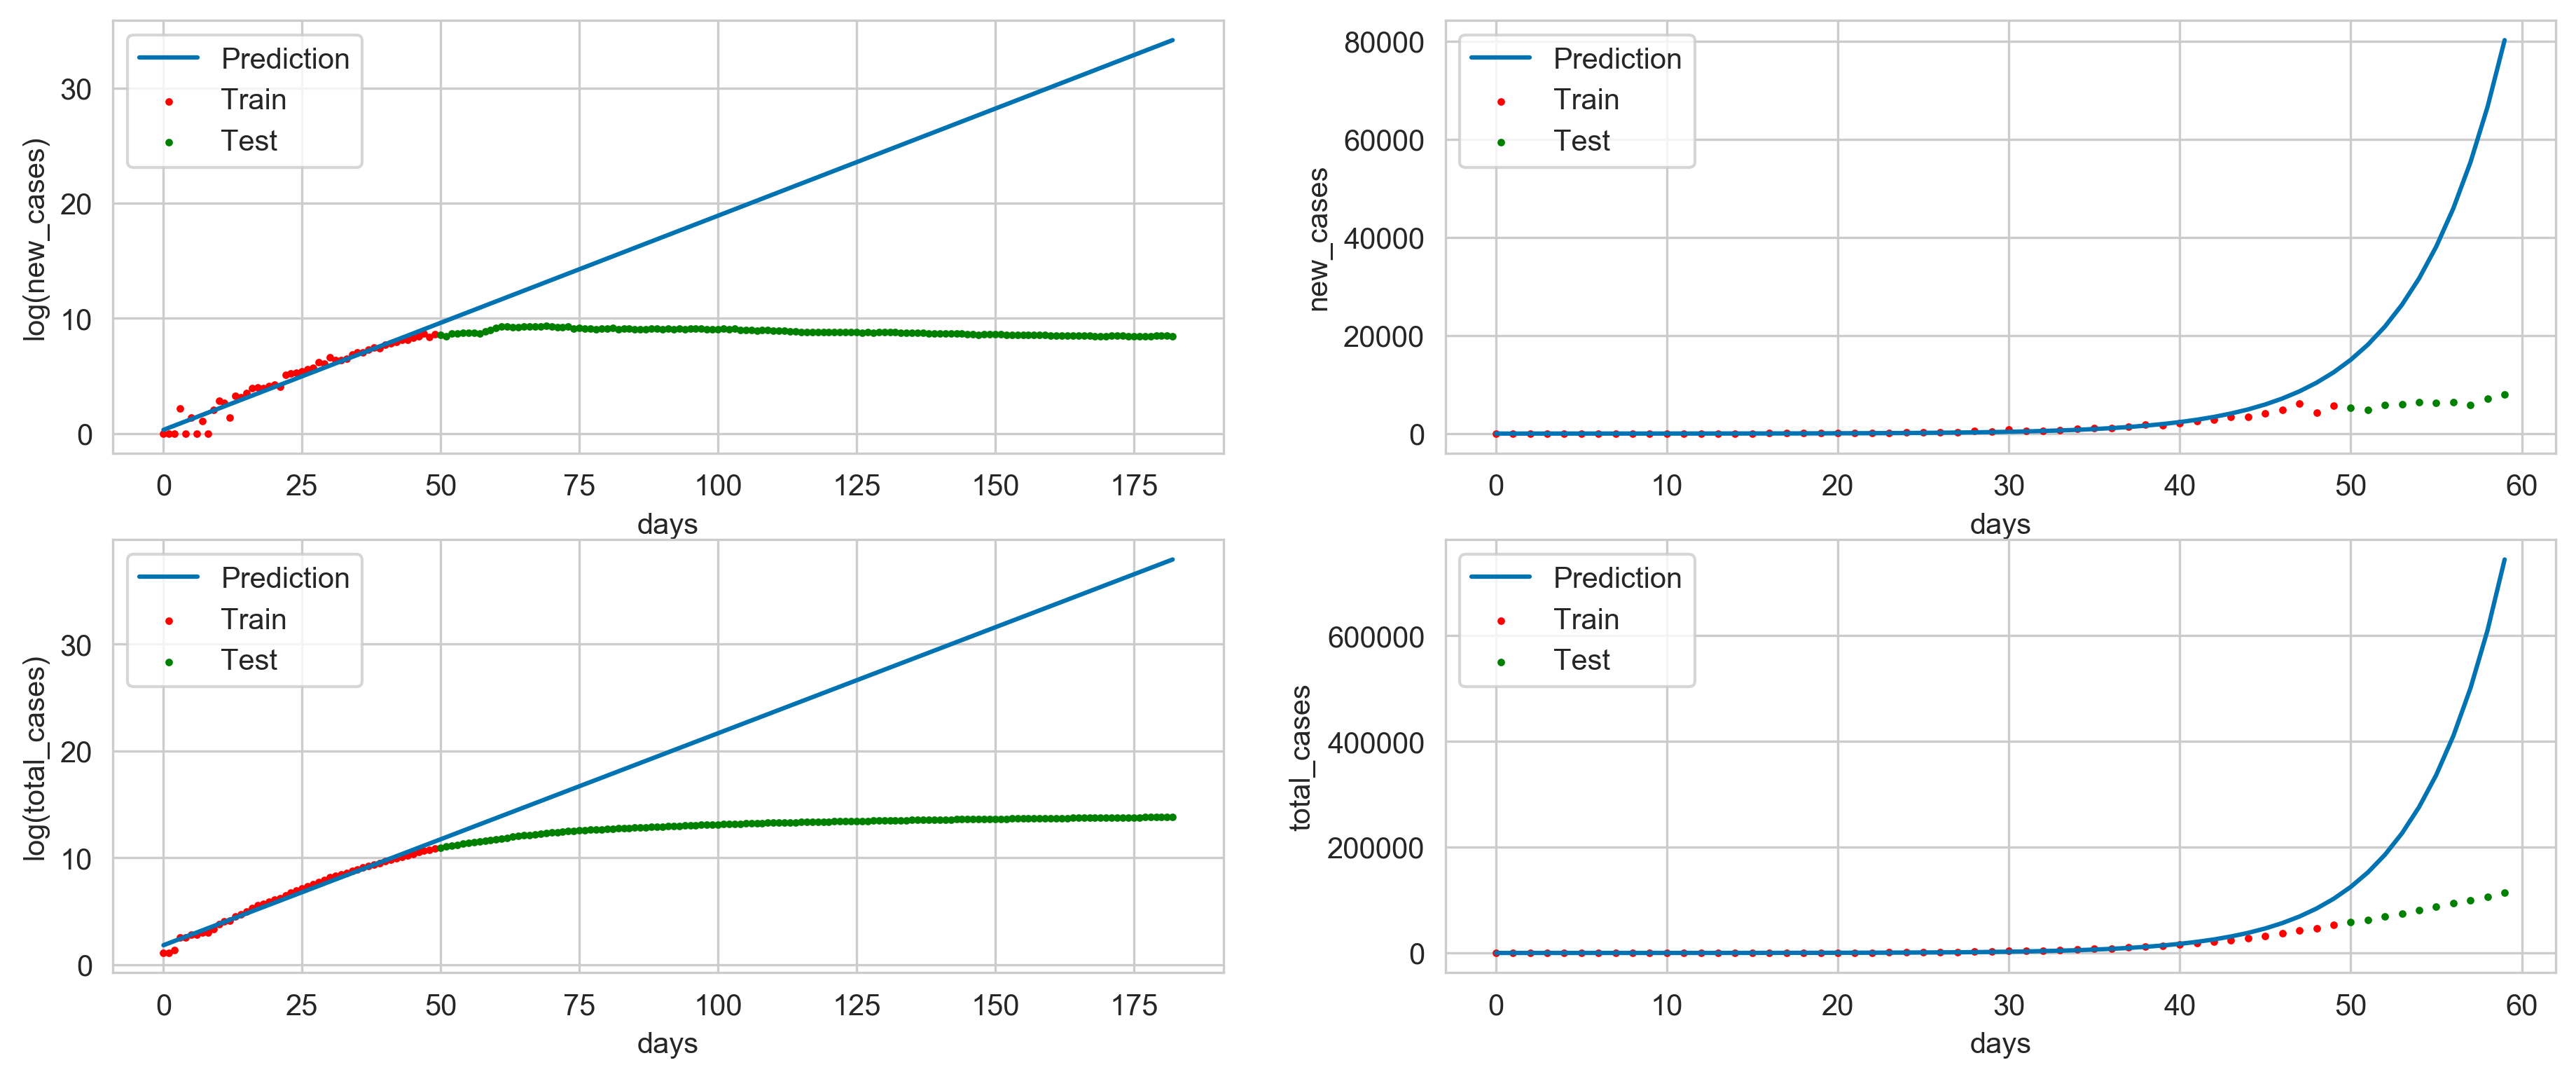

In [2231]:
train_days = np.arange(train.shape[0])
test_days = np.arange(test.shape[0]) + train_days.shape[0]

axis_fontsize = 10
plt.figure(figsize=(15, 6))

plt.subplot(221)
plt.scatter(train_days, np.log(train.new_cases), marker='.', s=10, color="red", label="Train")
plt.scatter(test_days, np.log(test.new_cases), marker='.', s=10, color="green", label="Test")
plt.plot(np.hstack((train_days, test_days)),\
         cur_model_new_cases.predict(np.hstack((train_days, test_days)).reshape(-1, 1)), label="Prediction")
plt.xlabel("days", fontsize=axis_fontsize)
plt.ylabel("log(new_cases)", fontsize=axis_fontsize)
plt.legend(loc='upper left')

plt.subplot(222)
plt.scatter(train_days, train.new_cases, marker='.', s=10, color="red", label="Train")
plt.scatter(test_days[:10], test.new_cases[:10], marker='.', s=10, color="green", label="Test")
plt.plot(np.hstack((train_days, test_days[:10])),\
         np.exp(cur_model_new_cases.predict(np.hstack((train_days, test_days[:10])).reshape(-1, 1))), label="Prediction")
plt.xlabel("days", fontsize=axis_fontsize)
plt.ylabel("new_cases", fontsize=axis_fontsize)
plt.legend(loc='upper left')

plt.subplot(223)
plt.scatter(train_days, np.log(train.total_cases), marker='.', s=10, color="red", label="Train")
plt.scatter(test_days, np.log(test.total_cases), marker='.', s=10, color="green", label="Test")
plt.plot(np.hstack((train_days, test_days)),\
         cur_model_total_cases.predict(np.hstack((train_days, test_days)).reshape(-1, 1)), label="Prediction")
plt.xlabel("days", fontsize=axis_fontsize)
plt.ylabel("log(total_cases)", fontsize=axis_fontsize)
plt.legend(loc='upper left')

plt.subplot(224)
plt.scatter(train_days, train.total_cases, marker='.', s=10, color="red", label="Train")
plt.scatter(test_days[:10], test.total_cases[:10], marker='.', s=10, color="green", label="Test")
plt.plot(np.hstack((train_days, test_days[:10])),\
         np.exp(cur_model_total_cases.predict(np.hstack((train_days, test_days[:10])).reshape(-1, 1))), label="Prediction")
plt.xlabel("days", fontsize=axis_fontsize)
plt.ylabel("total_cases", fontsize=axis_fontsize)
plt.legend(loc='upper left')

plt.show()

B. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

Возьмем:
$\sigma_0^2$ = 2 ($\approx2*\sigma^2$) для апостериорного распределения.
Дисперсию шума в данных $\sigma^2$ оценим, исходя из максимальной апостериорной модели (mse ошибка).

In [2232]:
sigma_noise = cur_model_total_cases.score(train_days.reshape(-1, 1), np.log(train.total_cases))
sigma_0 = 2
sigma_noise

0.985339421227631

In [2233]:
X = np.ones((train.shape[0], 2))
X[:, 1] = train_days
sigma_n = np.linalg.inv(np.eye(2) * (1/sigma_0) + (X.T @ X) / sigma_noise)
mu_n = sigma_n @ (X.T @ np.log(np.asarray(train.total_cases))) / sigma_noise

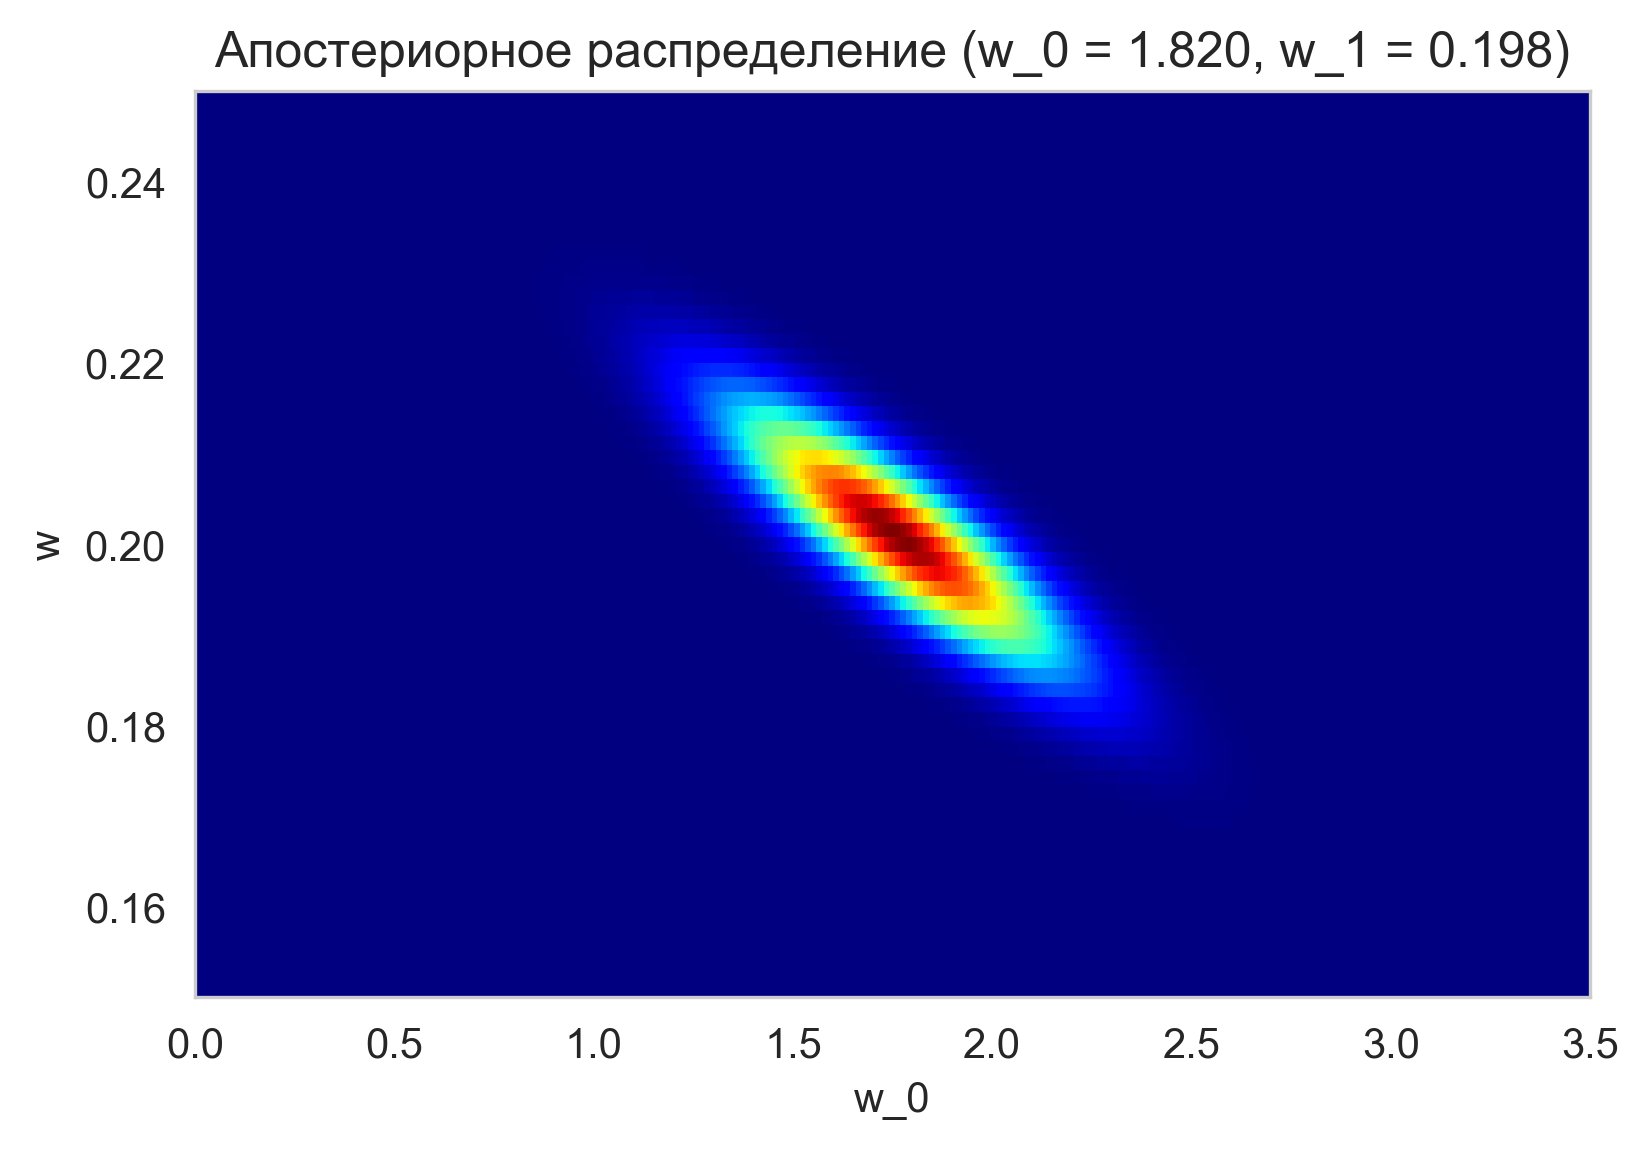

In [2234]:
N = 250
X = np.linspace(0, 3.5, N)
Y = np.linspace(0, 0.4, N)
X, Y = np.meshgrid(X, Y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

Z = multivariate_normal.pdf(pos, mean = mu_n, cov = sigma_n)

def myplot_heatmap(Z):
    # Make the plot
    plt.xlim((0, 3.5))
    plt.ylim((0.15, 0.25))
    plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
    plt.ylabel('w')
    plt.xlabel('w_0')
    
myplot_heatmap(Z)
plt.title('Апостериорное распределение (w_0 = 1.820, w_1 = 0.198)')
plt.show()

C. Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая 2020 года? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).


In [2235]:
may_1 = datetime.date(2020, 5, 1) - datetime.date(2020, 3, 3)
june_1 = datetime.date(2020, 6, 1) - datetime.date(2020, 3, 3)
sep_1 = datetime.date(2020, 9, 1) - datetime.date(2020, 3, 3)
(may_1.days, june_1.days, sep_1.days)

(59, 90, 182)

In [2236]:
weights = np.random.multivariate_normal(mu_n, sigma_n, 1000)

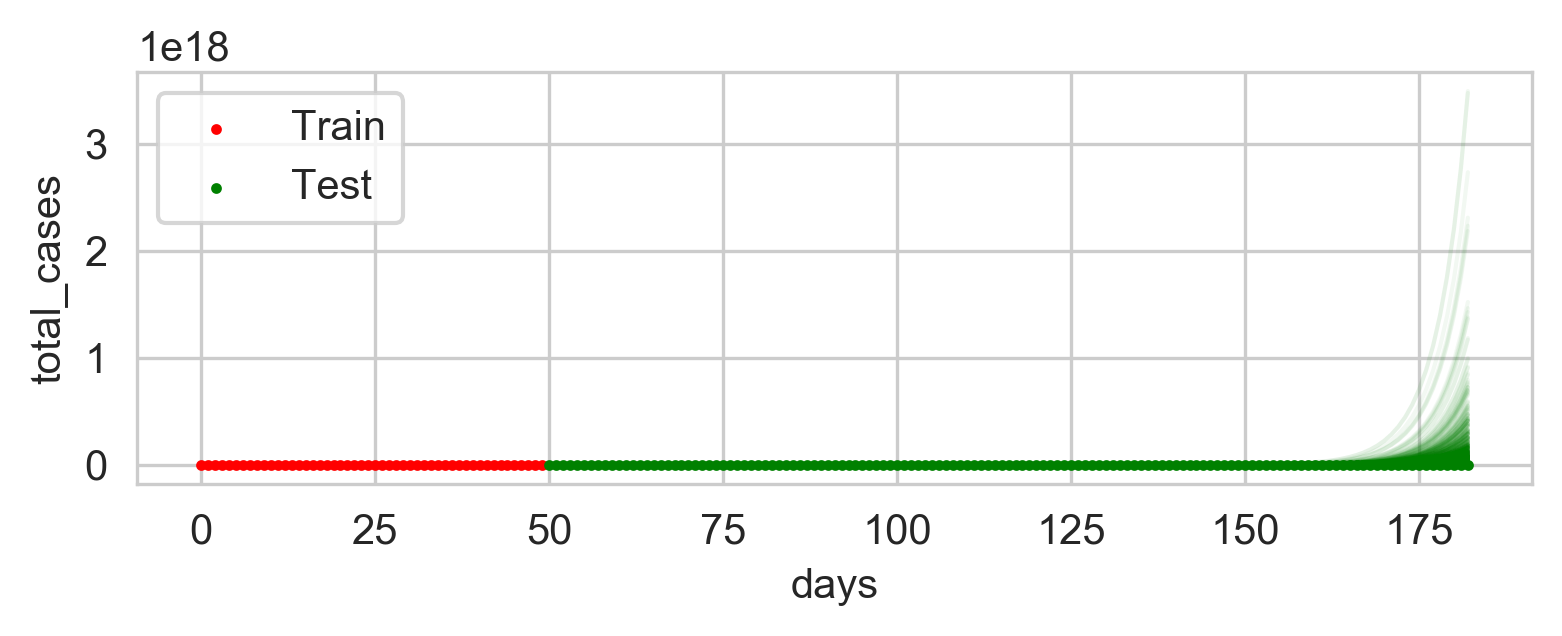

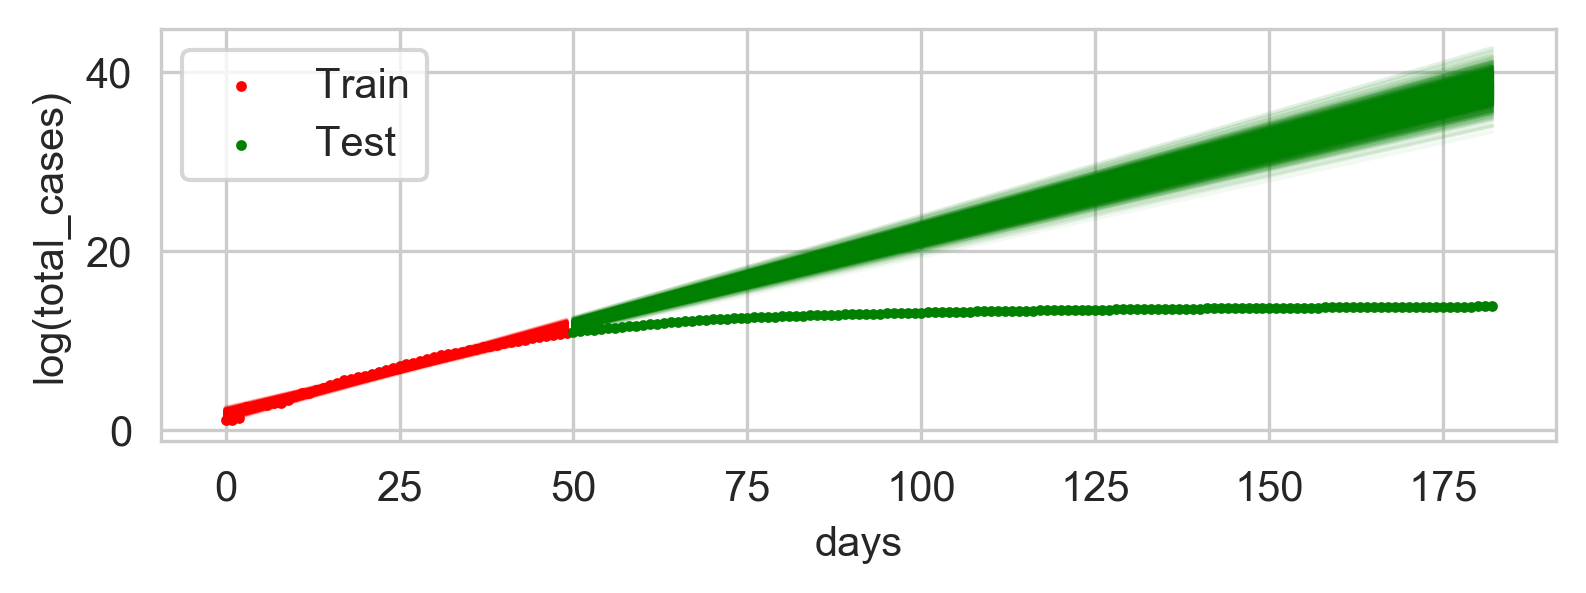

In [2237]:
may_1 = []
june_1 = []
september_1 = []

plt.subplot(211)
for weight in weights:
    cur_model_total_cases.coef_[0] = weight[1]
    cur_model_total_cases.intercept_ = weight[0]
    train_predict = np.exp(cur_model_total_cases.predict(train_days.reshape(-1, 1)))
    test_predict = np.exp(cur_model_total_cases.predict(test_days.reshape(-1, 1)))
      
    plt.plot(train_days, train_predict,  '-', linewidth=1, color='red', alpha=0.05)
    plt.plot(test_days, test_predict,  '-', linewidth=1, color='green', alpha=0.05)
    
    may_1.append(test_predict[9])
    june_1.append(test_predict[40])
    september_1.append(test_predict[132])  
    
plt.scatter(train_days, train.total_cases, marker='.', s=10, color="red", label="Train")
plt.scatter(test_days, test.total_cases, marker='.', s=10, color="green", label="Test")    
plt.xlabel('days')
plt.ylabel('total_cases')
plt.legend(loc='upper left')
plt.show() 
    
plt.subplot(212)    
for weight in weights:
    cur_model_total_cases.coef_[0] = weight[1]
    cur_model_total_cases.intercept_ = weight[0]
    train_predict = cur_model_total_cases.predict(train_days.reshape(-1, 1))
    test_predict = cur_model_total_cases.predict(test_days.reshape(-1, 1))
      
    plt.plot(train_days, train_predict,  '-', linewidth=1, color='red', alpha=0.05)
    plt.plot(test_days, test_predict,  '-', linewidth=1, color='green', alpha=0.05)
           
plt.scatter(train_days, np.log(train.total_cases), marker='.', s=10, color="red", label="Train")
plt.scatter(test_days, np.log(test.total_cases), marker='.', s=10, color="green", label="Test")    
plt.xlabel('days')
plt.ylabel('log(total_cases)')
plt.legend(loc='upper left')
plt.show() 



Предсказательные распределения, полученные из данных сэмплирования.

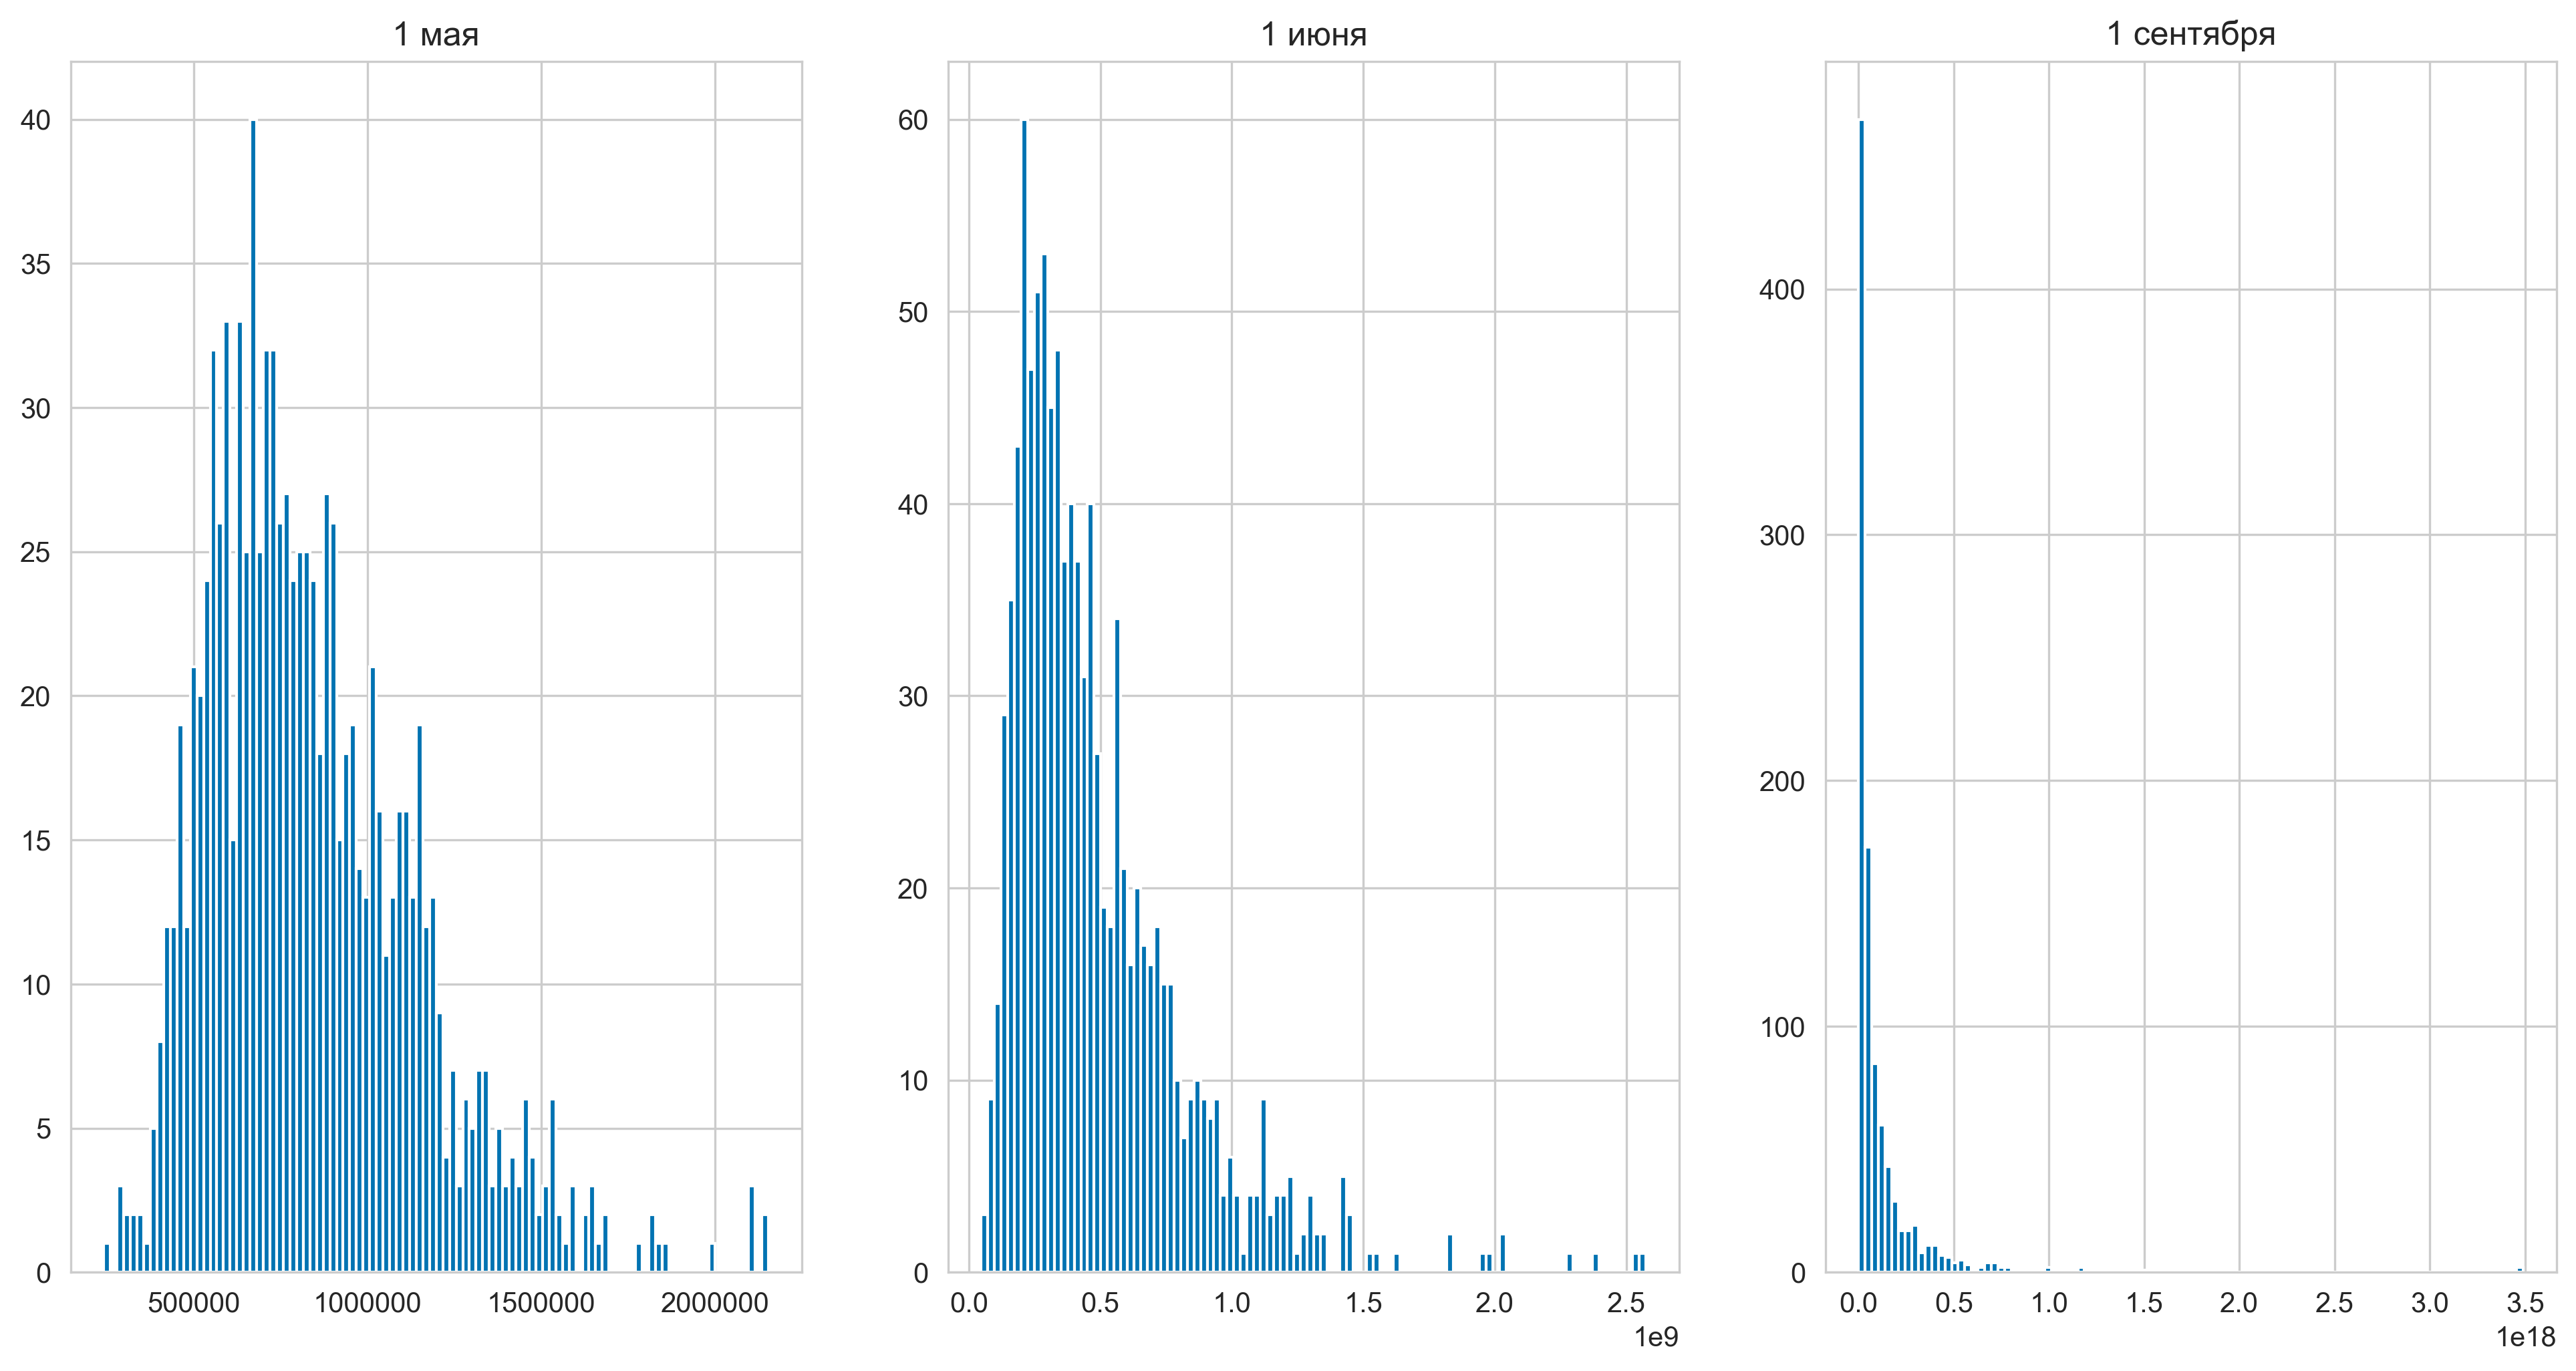

In [2238]:
fig = plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.hist(may_1, bins=100)
plt.title('1 мая')
plt.subplot(132)
plt.hist(june_1, bins=100)
plt.title('1 июня')
plt.subplot(133)
plt.hist(september_1, bins=100)
plt.title('1 сентября')

plt.show()

In [2239]:
distr = {'may_1': [np.mean(may_1), np.std(may_1)], 'june_1': [np.mean(june_1), np.std(june_1)], 'september_1': [np.mean(september_1), np.std(september_1)]}

In [2240]:
pd.DataFrame(distr, index=['mean', 'std'])

,may_1,june_1,september_1
mean,840916.483918,4.827842e+08,1.210705e+17
std,302434.484543,3.316753e+08,2.747670e+17


3. Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана. Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t.

$$\phi(x) = \int_{-\infty}^x e^{w_2*t^2 + w_1*t + w_0}dt$$

А. Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.

Согласно Теореме о производной интеграла по переменной верхней границе:

$$\frac{d\int_{a}^x f(t)dt}{dx} = f(x)$$

В качестве целевой переменной возьмем ежедневный прирост - new_cases, тогда:

$$new\;cases = y' = (\frac{d\int_{a}^x f(t)dt}{dx})' = f(x) = e^{w_2*t^2 + w_1*t + w_0}$$

$$ln(new\;cases) = w_2*t^2 + w_1*t + w_0$$

B. Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.

In [2241]:
border = 50
top = 183
#фильтруем данные: Россия, начиная с 3 марта, заменяем 0.0 в столбце 'new_cases' на 1.
data_ru = data[data['location'] == 'Russia'][data['date'] >= '2020-03-03']
data_ru['new_cases'].replace(0, 1., inplace=True)
train = data_ru[:border]
# 1 сентября 2020 года это 183-й день начиная с 3 марта 2020
test = data_ru[border:top]
train_days = np.arange(train.shape[0])
test_days = np.arange(test.shape[0]) + train_days.shape[0]

C:\Users\shubi\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [2242]:
train_sigmoid = np.ones((train_days.shape[0], 3))
for i in range(train_days.shape[0]):
    train_sigmoid[i][0] = 1
    train_sigmoid[i][1] = train_days[i]
    train_sigmoid[i][2] = train_days[i]**2
train_target = np.log(train['new_cases'])

In [2243]:
test_sigmoid = np.ones((test_days.shape[0], 3))               
for i in range(test_days.shape[0]):
    test_sigmoid[i][0] = 1
    test_sigmoid[i][1] = test_days[i]
    test_sigmoid[i][2] = test_days[i]**2
test_target = np.log(test['new_cases'])

In [2244]:
def total_cases(new_cases):
    for i in range(1,len(new_cases)):
        new_cases[i] = new_cases[i] + new_cases[i - 1]
    return new_cases

In [2245]:
cur_model = linear_model.LinearRegression(fit_intercept=False).fit(train_sigmoid, train_target)

In [2246]:
predictions = total_cases(np.exp(cur_model.predict(np.vstack((train_sigmoid[:border], test_sigmoid)))))

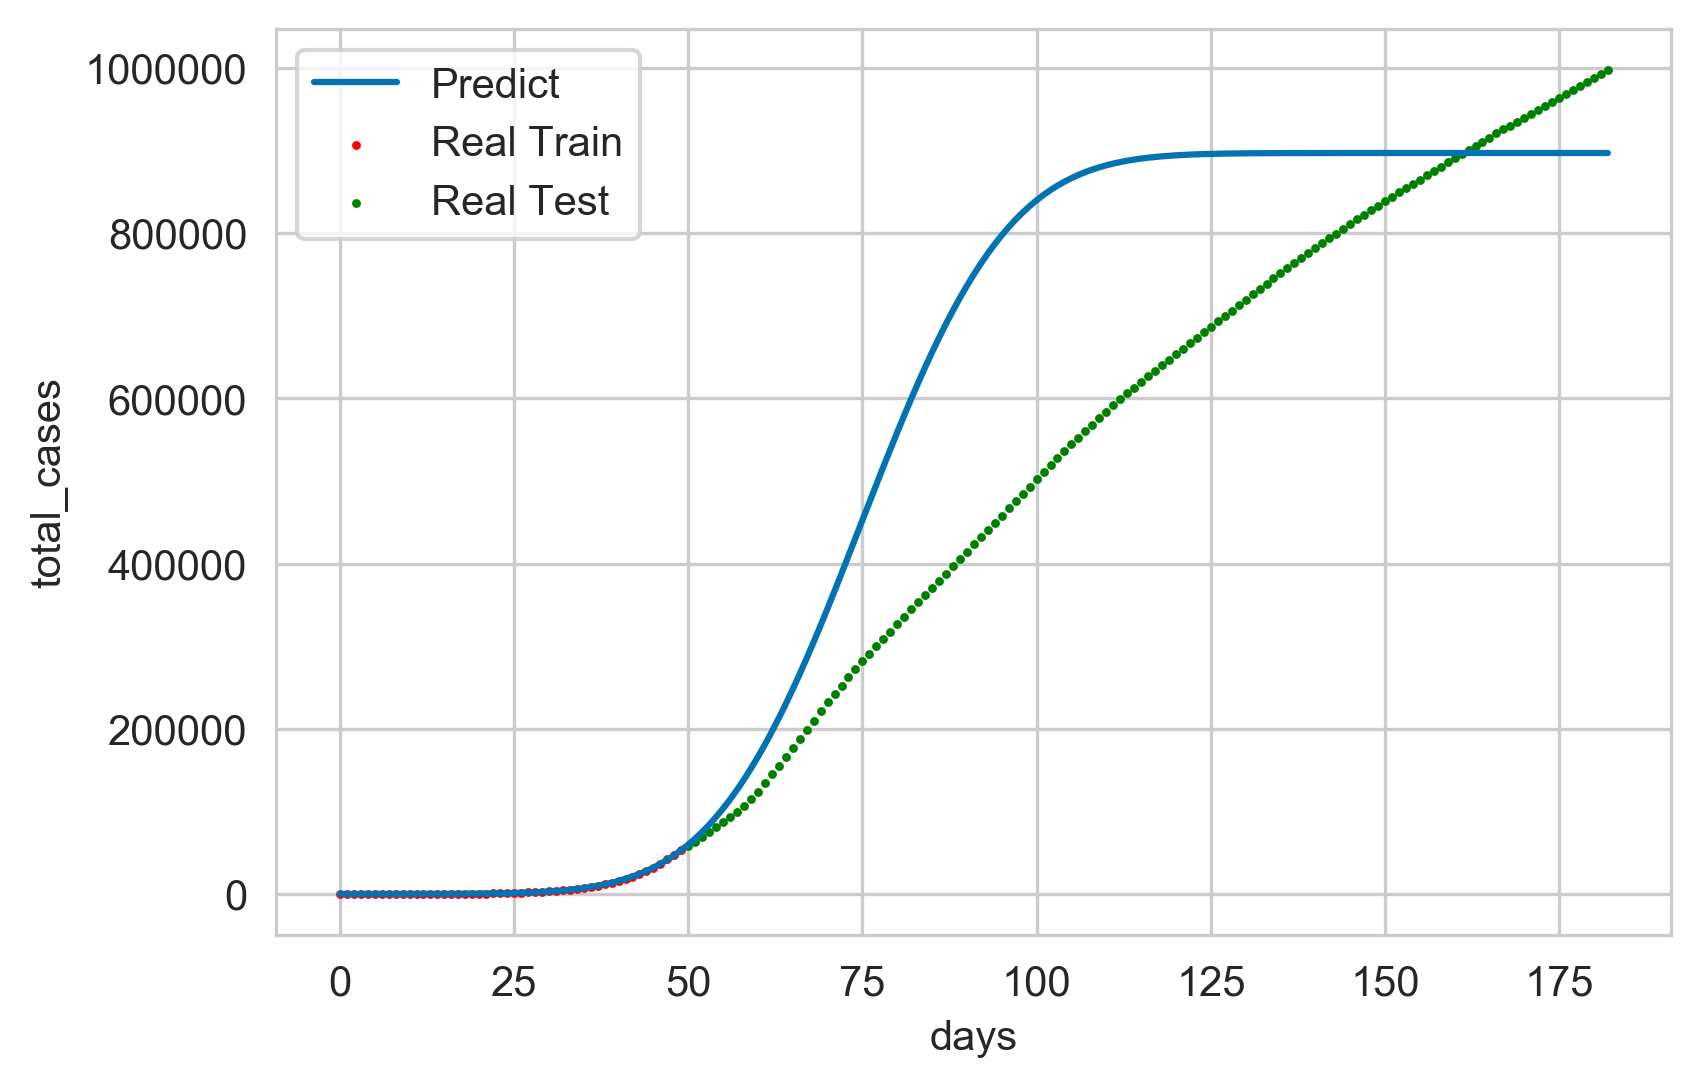

In [2247]:
plt.scatter(train_days, train.total_cases, marker='.', s=5, color="red", label="Real Train")
plt.scatter(test_days, test.total_cases, marker='.', s=5, color="green", label="Real Test")
plt.plot(np.arange(0,top,1), predictions, label="Predict")
plt.legend(loc='upper left')
plt.xlabel('days')
plt.ylabel('total_cases')
plt.show()

In [2248]:
def total_cases(new_cases):
    for i in range(1,len(new_cases)):
        new_cases[i] = new_cases[i] + new_cases[i - 1]
    return new_cases

In [2249]:
sigma_noise = cur_model.score(train_sigmoid, train_target)
print(sigma_noise)
sigma_0 = 2

X = train_sigmoid
sigma_n = np.linalg.inv(np.eye(3)*(1/sigma_0) + (X.T @ X) / sigma_noise)
mu_n = sigma_n @ (X.T @ np.asarray(train_target)) / sigma_noise
print(f"sigma_n = {sigma_n} mu_n = {mu_n}")

0.9683360173111185
sigma_n = [[ 1.48990855e-01 -1.20353095e-02  2.02595197e-04]
 [-1.20353095e-02  1.35558285e-03 -2.60481486e-05]
 [ 2.02595197e-04 -2.60481486e-05  5.36329798e-07]] mu_n = [-0.36538744  0.27304945 -0.00178603]


C. Посэмплируйте много разных сигмоид из апостериорного распределения, постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России? Постройте эмпирическое предсказательное распределение, нарисуйте графики. Каков ваш прогноз числа случаев коронавируса в пессимистичном сценарии (90-й процентиль в выборке числа случаев)? В оптимистичном сценарии (10-й процентиль)?

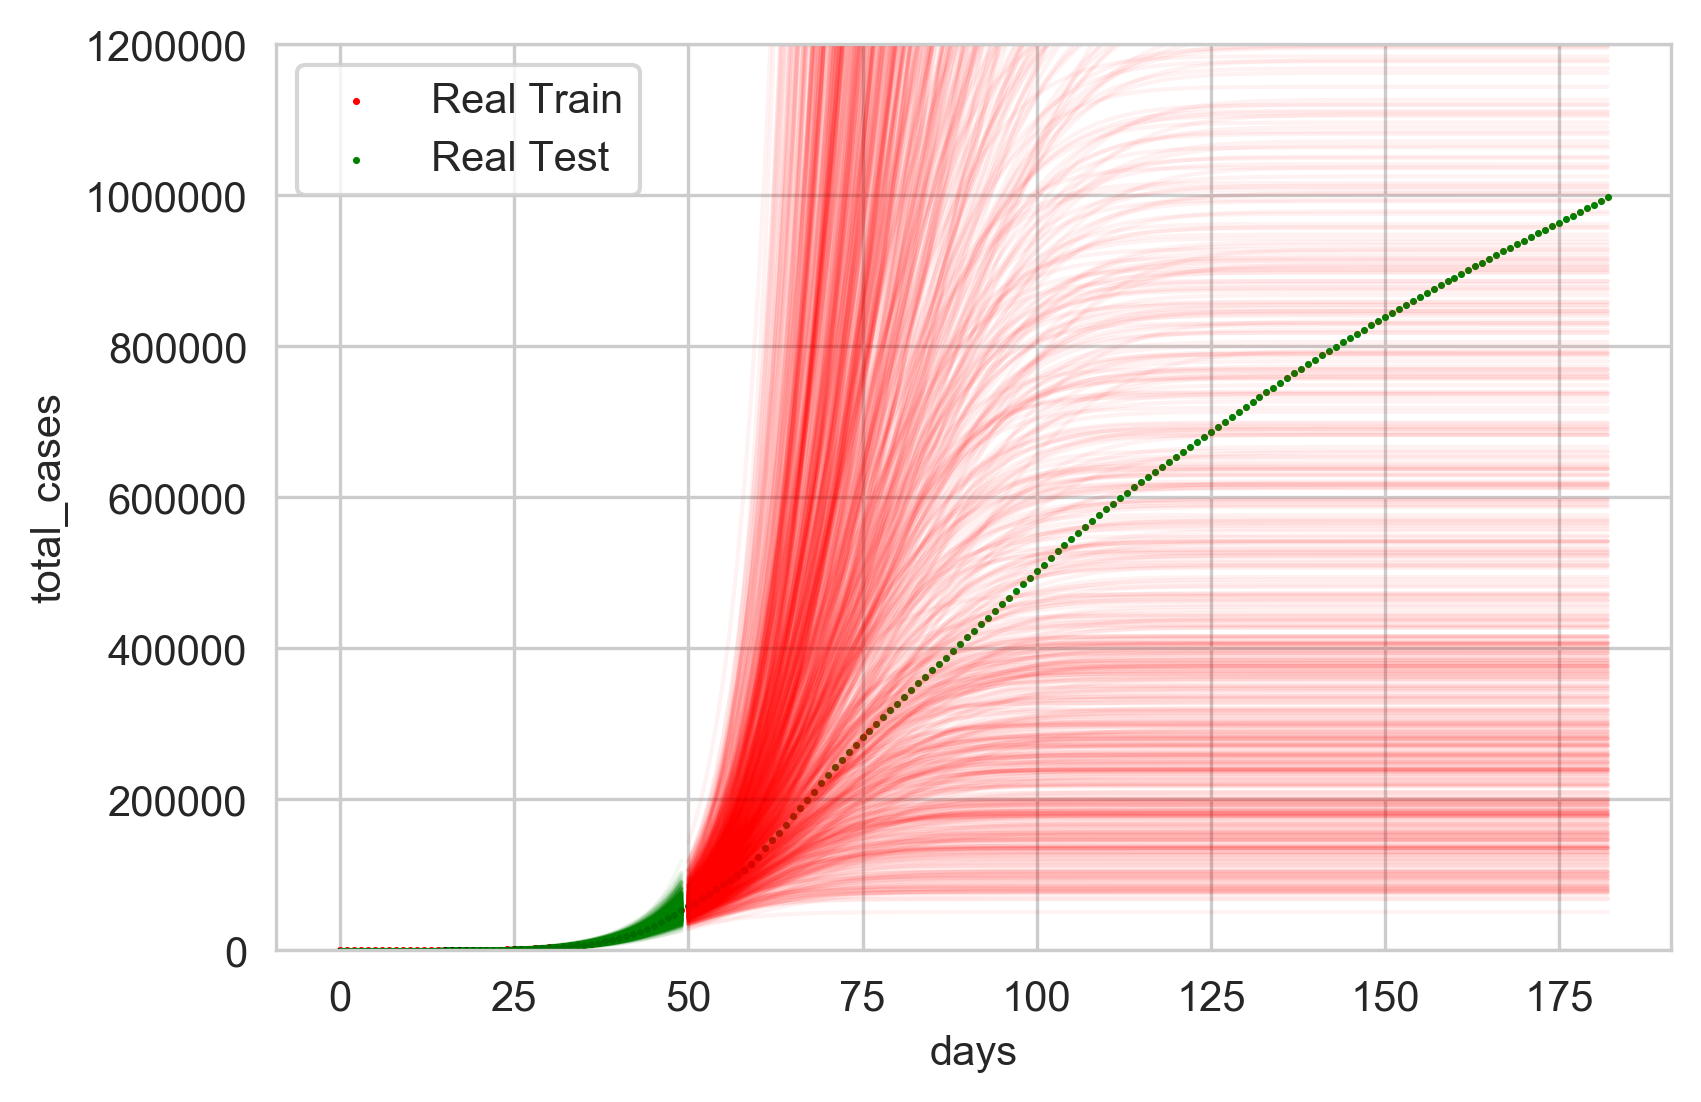

In [2250]:
weights = np.random.multivariate_normal(mu_n, sigma_n, 1000)

may_1 = []
june_1 = []
september_1 = []
percentile_may_1 = []
percentile_june_1 = []
percentile_september_1 = []

for weight in weights:
    cur_model.coef_ = weight
     
    train_predict = np.exp(cur_model.predict(train_sigmoid))
    test_predict = np.exp(cur_model.predict(test_sigmoid))
    
    train_predict_total =  total_cases(train_predict)
    test_predict_total =  total_cases(test_predict) +  train_predict_total[-1]
    
    plt.plot(train_days, train_predict_total,  '-', linewidth=1, color='green', alpha=0.05)
    plt.plot(test_days, test_predict_total,  '-', linewidth=1, color='red', alpha=0.05)
    
    may_1.append(test_predict_total[9])
    june_1.append(test_predict_total[40])
    september_1.append(test_predict_total[132])
   
    percentile_may_1.append(test_predict_total[9])
    percentile_june_1.append(test_predict_total[40])
    percentile_september_1.append(test_predict_total[132])
    
plt.scatter(train_days, train.total_cases, marker='.', s=2, color="red", label="Real Train")
plt.scatter(test_days, test.total_cases, marker='.', s=2, color="green", label="Real Test") 
plt.xlabel('days')
plt.ylabel('total_cases')
plt.legend(loc='upper left')
plt.ylim((0,1200000))
plt.show()  

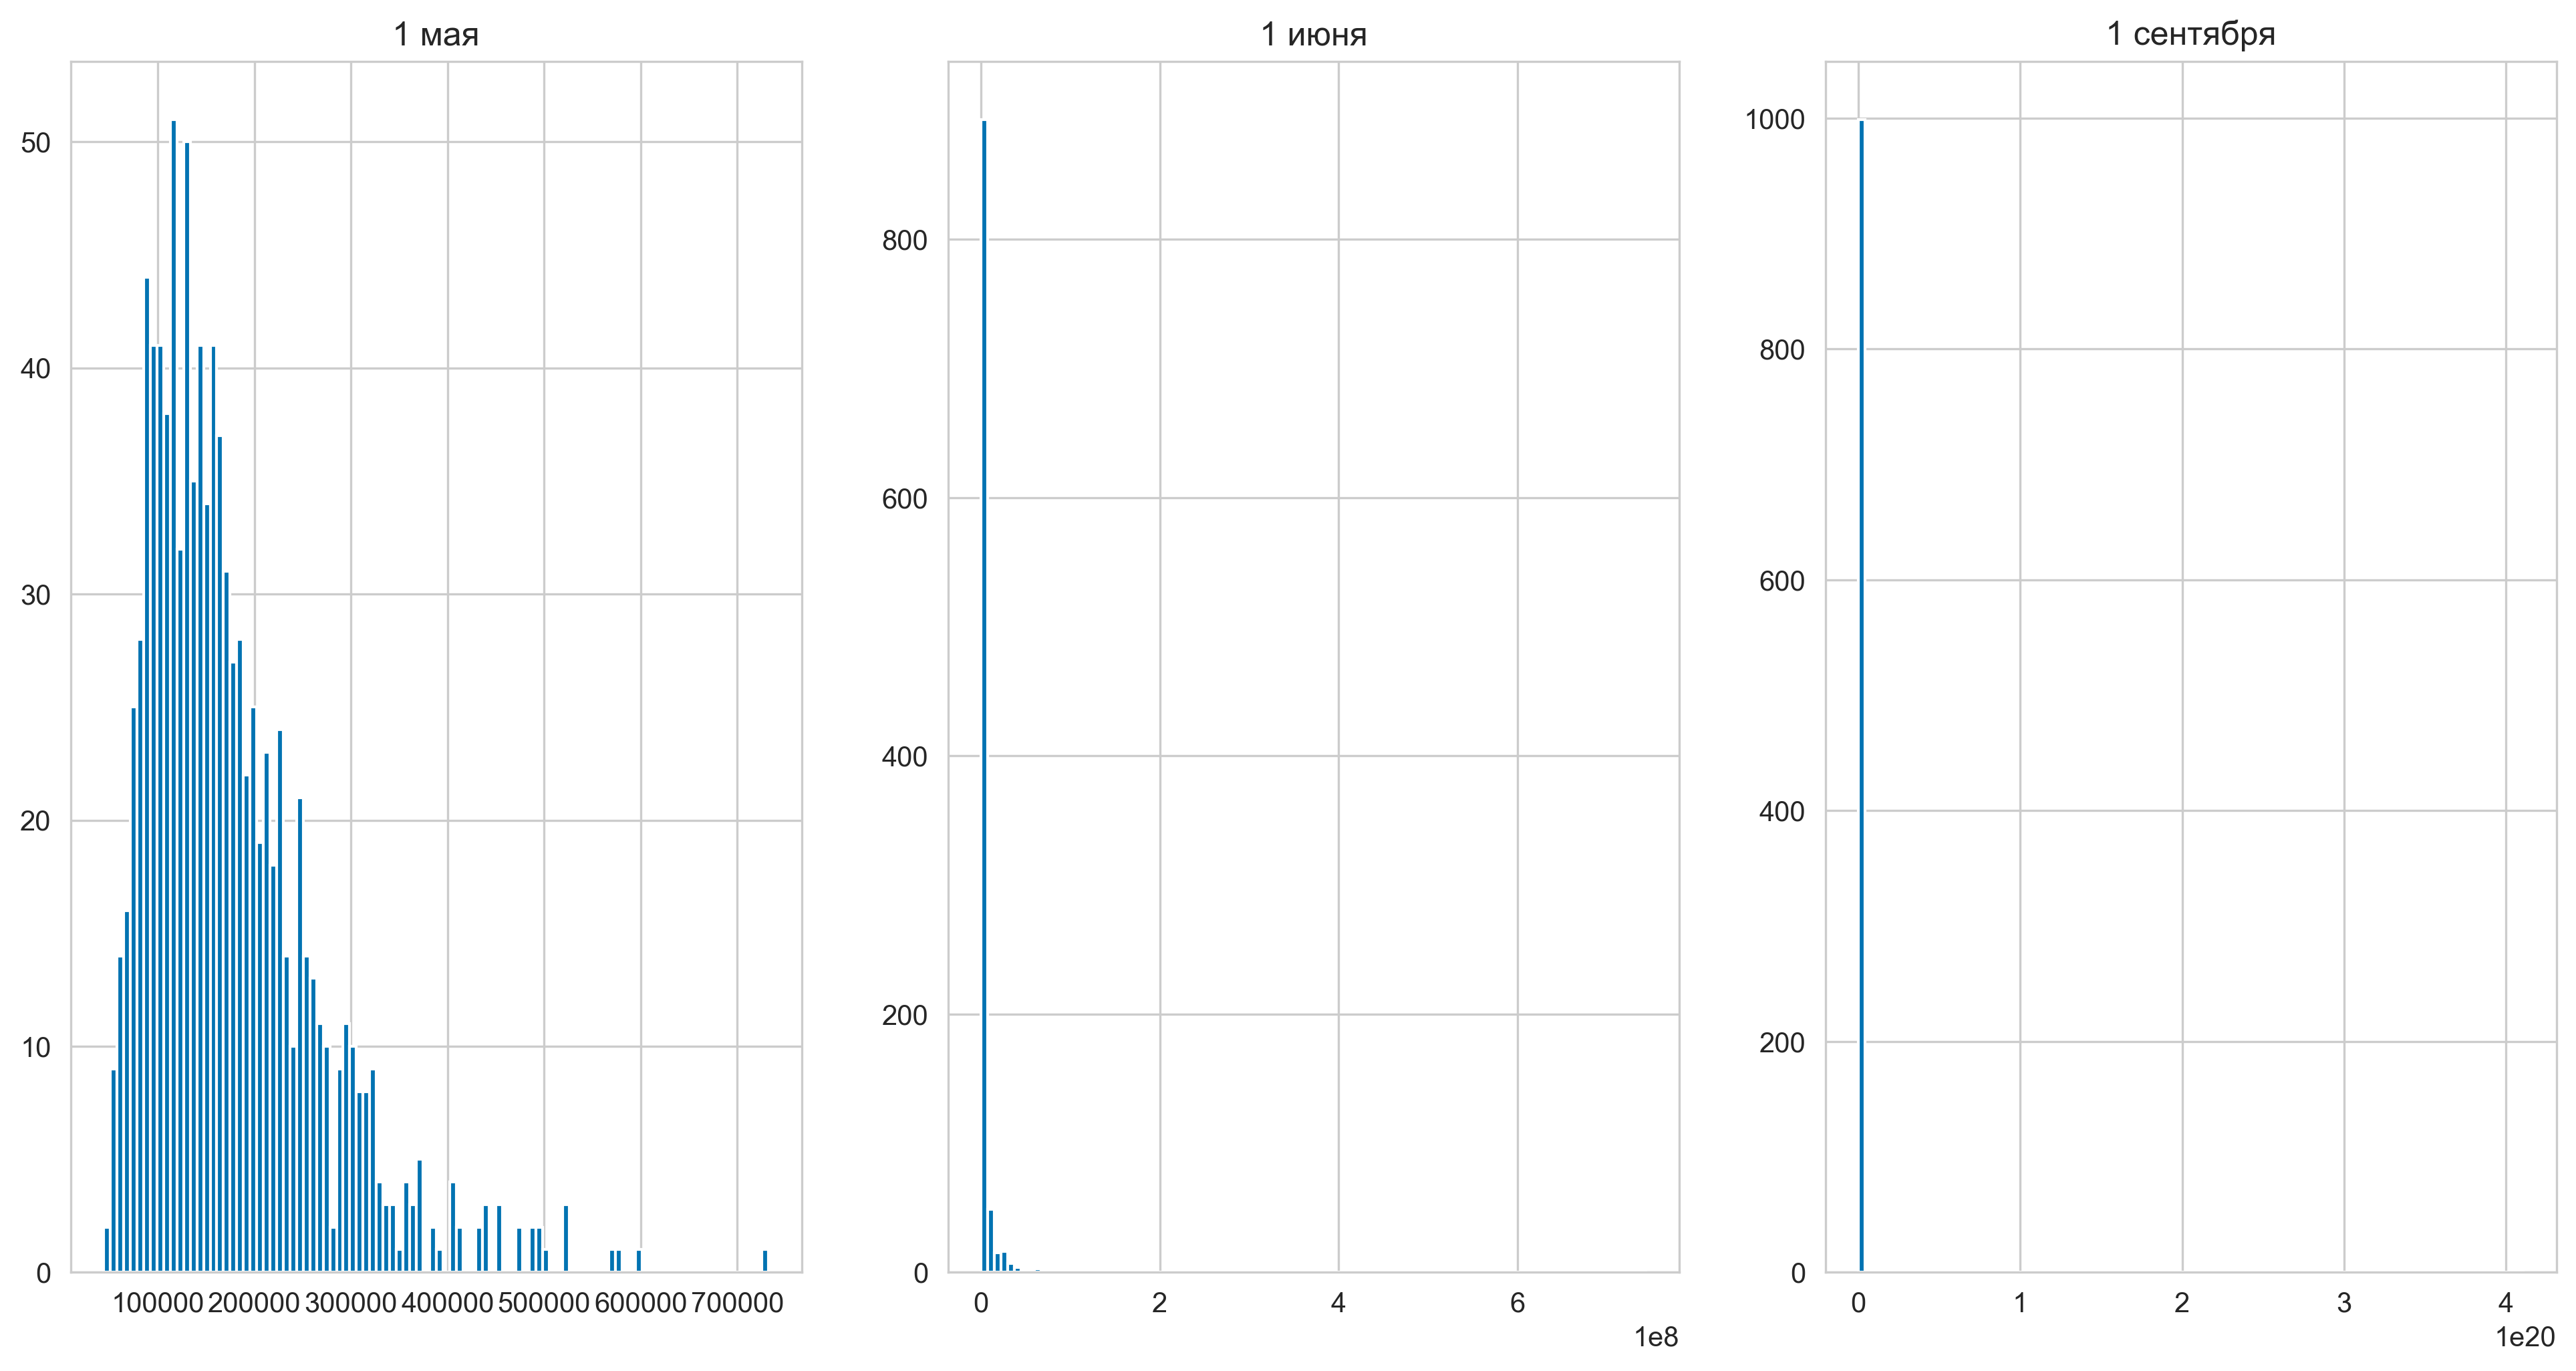

In [2251]:
fig = plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.hist(may_1, bins=100)
plt.title('1 мая')
plt.subplot(132)
plt.hist(june_1, bins=100)
plt.title('1 июня')
plt.subplot(133)
plt.hist(september_1, bins=100)
plt.title('1 сентября')

plt.show()

In [2252]:
distr = {'may_1': [np.mean(may_1), np.std(may_1)], 'june_1': [np.mean(june_1), np.std(june_1)], 'september_1': [np.mean(september_1), np.std(september_1)]}

In [2253]:
pd.DataFrame(distr, index=['mean', 'std'])

,may_1,june_1,september_1
mean,173610.065307,4.975476e+06,4.116463e+17
std,88215.458521,2.802905e+07,1.298022e+19


In [2254]:
print("Прогноз на 1 мая:")
print("10-й процентиль: %d, 90-й процентиль: %d." % (np.percentile(percentile_may_1, 10), np.percentile(percentile_may_1, 90))) 

print("Прогноз на 1 июня:")
print("10-й процентиль: %d, 90-й процентиль: %d." % (np.percentile(percentile_june_1, 10), np.percentile(percentile_june_1, 90)))

print("Прогноз на 1 сентября:")
print("10-й процентиль: %d, 90-й процентиль: %d." % (np.percentile(percentile_september_1, 10), np.percentile(percentile_september_1, 90)))


Прогноз на 1 мая:
10-й процентиль: 86086, 90-й процентиль: 290842.
Прогноз на 1 июня:
10-й процентиль: 171612, 90-й процентиль: 7829895.
Прогноз на 1 сентября:
10-й процентиль: 173061, 90-й процентиль: 113965953.


4. Бонус: проведите такой же анализ для других стран (здесь придётся руками подобрать дни начала моделирования — коронавирус приходил в разные страны в разное время). Насколько разные параметры получаются? Можно ли разделить страны на кластеры (хотя бы чисто визуально) в зависимости от этих параметров?

In [2255]:
all_country = np.unique(data['location'].values)

In [2256]:
def feature_data_prep(data, shift=0):
    data_sigmoid = np.ones((data.shape[0], 3))
    for i in range(data.shape[0]):
        data_sigmoid[i][0] = 1
        data_sigmoid[i][1] = i + shift
        data_sigmoid[i][2] = (i + shift)**2
    data_target = np.log(data['new_cases'])
    return (data_sigmoid, data_target)

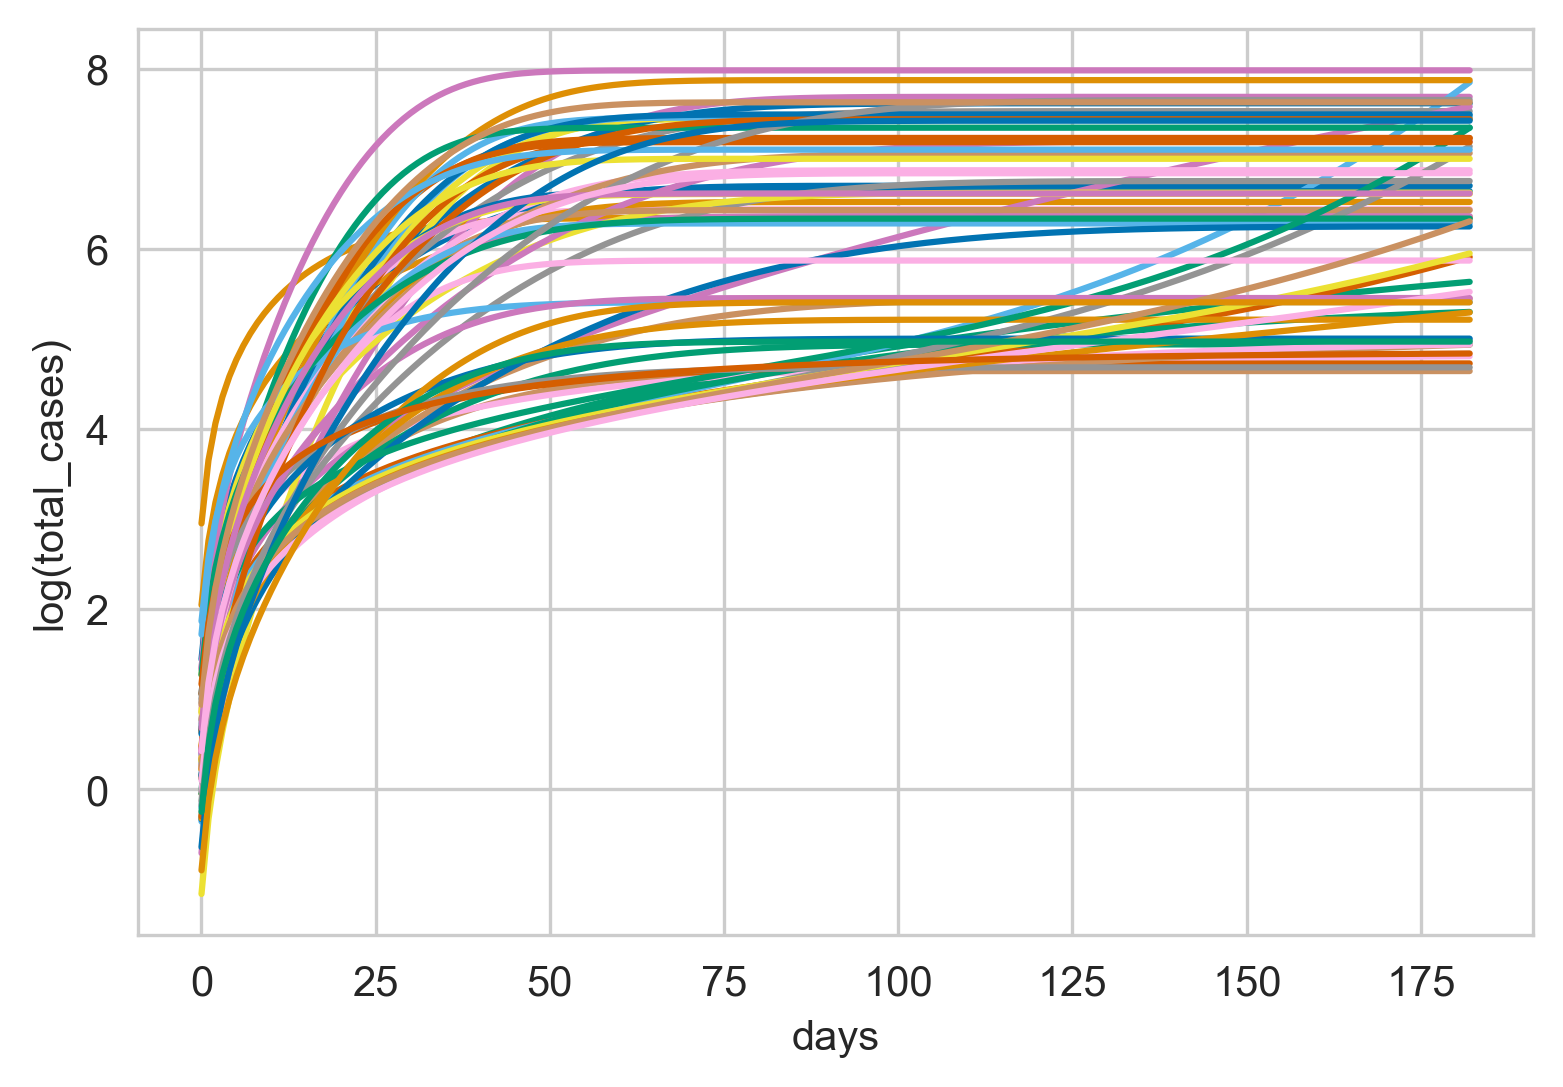

In [2276]:
border = 55
for country in all_country:
    try:
        #фильтруем данные: total_cases >= 3, заменяем 0.0 в столбце 'new_cases' на 1.
        data_ru = data[data['location'] == country][data['total_cases'] >= 3]
        data_ru['new_cases'].replace(0, 1., inplace=True)
        train = data_ru[:border]
        # 1 сентября 2020 года это 183-й день начиная с 3 марта 2020
        test = data_ru[border:183]

        train_sigmoid, train_target = feature_data_prep(train, shift=0)
        test_sigmoid, test_target = feature_data_prep(test, shift=border)

        cur_model = linear_model.LinearRegression(fit_intercept=False).fit(train_sigmoid, train_target)
        predictions = total_cases(np.exp(cur_model.predict(np.vstack((train_sigmoid, test_sigmoid)))))
        
        if predictions[-1] > np.exp(10):
            continue
        if predictions[-1] > np.exp(8):
            top.append(country)
        plt.plot(np.arange(0,183,1), np.log(predictions))
    except:
        continue
  
#plt.legend(loc='upper left')
plt.xlabel('days')
plt.ylabel('log(total_cases)')
plt.show()


Насколько разные параметры получаются?

Параметры варьируются в очень широком диапазоне.

Можно ли разделить страны на кластеры (хотя бы чисто визуально) в зависимости от этих параметров?

При размере обучающей выборке равном 55 дням, наблюдается достаточно широкая граница между двумя областями, см. рис. выше.
Возможно это связано с плохо поставленным сбором статистики в данных странах, т.к. преимущественно эти страны не благополучные.

5. Что вы поняли из этого упражнения? Что можно сказать про коронавирус по итогам такого моделирования? Как принять решение, например, о том, нужно ли вводить карантин?


Cтоит отметить, что сигмоида функции распределения для гауссиана плохо подходит для нашей задачи,
т.к. вторая волна вируса исказила фазу насыщения. Но это можно использовать на пользу - как некоторый признак начала второй волны.
Начало второй волны можно было определить в диапазоне между 90 и 100 днем от 3 марта (см. рисунки ниже). Именно тогда качество аппроксимацией нашей функцией начало снижаться. Именно по этим данным, можно было судить о начале второй волны и принять решение о введении карантина.

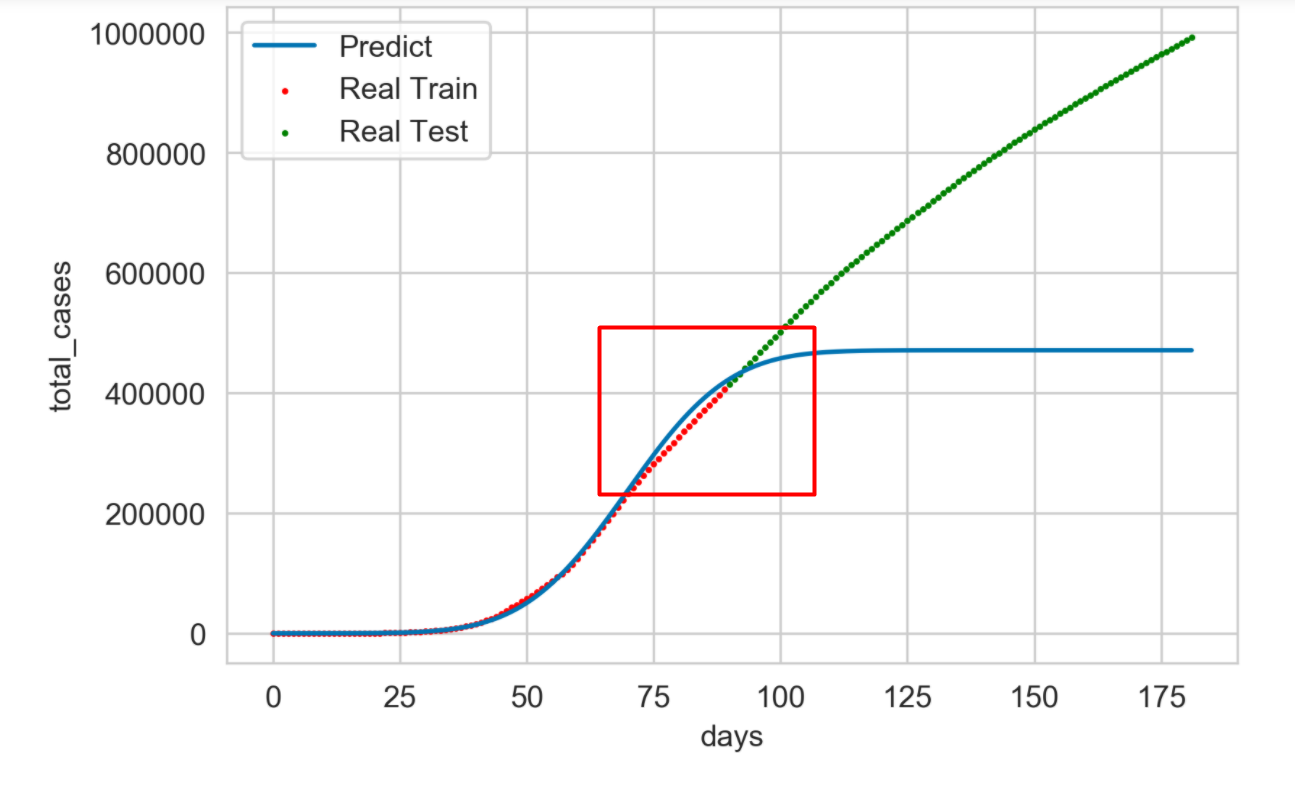

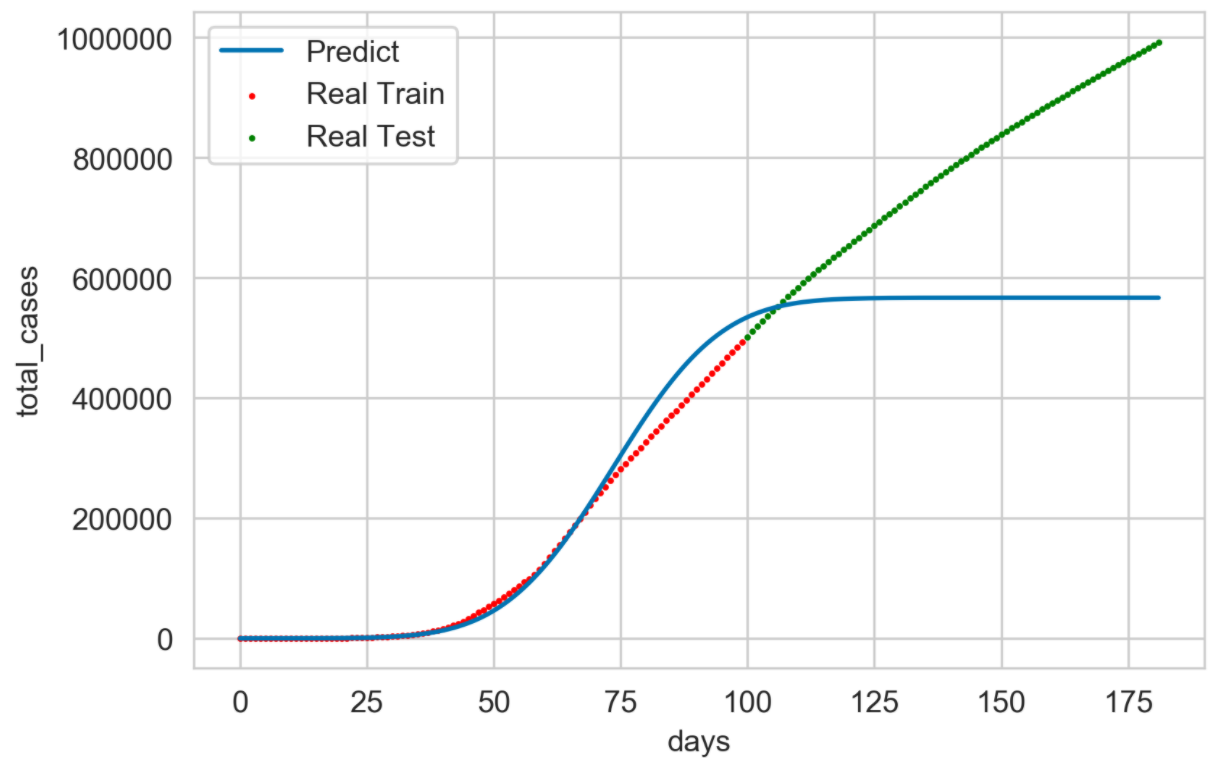